1. Test sklearn’s TfidfVectorizer inplace of CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?
2. Test different lengths of n-grams in the CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value? Do these n-grams show up also in the list of most significant positive/negative features?
3. In the data package for the course (http://dl.turkunlp.org/intro-to-nlp.tar.gz), the directory language_identification contains data for 5 languages. Based on this data, train an SVM classifier for language recognition between these 5 languages.
4. If you completed (3), toy around with features, especially the ngram_range and analyzer parameters, which allow you to test classification based on character ngrams of various lengths (not only word n-grams). Gain some insight into the accuracy of the classifier with different features, and try to identify misclassified documents - why do you think they were misclassified?
5. On the address universal dependencies.org, you will find datasets for a bunch of languages. These come in an easy-to-parse, well-documented format. Pick one language that interests you, and one tree bank for that language, and try to build a POS tagger for this language. You can use the 4th column “UPOS” https://universaldependencies.org/format.htmlReportonyourfindings. If you have extra time, try to experiment with various features and see if you can make your accuracy go up. You can check here https://universaldependencies.org/conll18/results-upos.html what the state of the art roughly is for your selected language and treebank. Did you come close?


In [171]:
import os
import json
import random
# import sklearn
import mglearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [153]:
def draw_param_heatmap(
    param_grid,
    x_grid, y_grid,
    df_result,
    summarize='mean'
):
    """
    Draw a heatmap based on 2 parameters grid.
    
    Parameters:
    ----------
    
    param_grid: dict
        Provide the dictionary of parameters,
        the names of the parameterr provide in x_grid
        and y_grid should be available in this dictionary
    x_grid: string/object
        Name of the parameter to be plotted
        on the x axis. The name should be exactly same
        as one of the key in the 'param_grid'
    y_grid: string/object
        Name of the parameter to be plotted
        on the y axis. The name should be exactly same
        as one of the key in the 'param_grid'
    df_result: Pandas Dataframe
        Obtain from the 'cv_results_' attribute of GridSearch
    summarize: string/object
        Choose the summarization method for the score
        since there are more than 1 score. And unless 'sum'
        is explicitly stated, the score will always be
        mean/average
    
    Returns:
    -------
    None:
        No return, just plot the heatmap
    """

    # Prepare an empty dataframe
    df_heatmap = pd.DataFrame(
        index=param_grid[y_grid],
        columns=param_grid[x_grid],
        dtype=np.float32
    )

    # Fill the empty data frame
    # With total score from other parameters
    col_min = None
    col_max = None
    for k, i in enumerate(param_grid[y_grid]):
        for l, j in enumerate(param_grid[x_grid]):
            if summarize == 'sum':
                df_heatmap.loc[i, j] = df_result[
                    (df_result['param_'+y_grid] == i) &
                    (df_result['param_'+x_grid] == j)
                ]['mean_test_score'].sum()
            else:
                df_heatmap.loc[i, j] = df_result[
                    (df_result['param_'+y_grid] == i) &
                    (df_result['param_'+x_grid] == j)
                ]['mean_test_score'].mean()
            if not col_max:
                col_max = df_heatmap.iloc[k, l]
            else:
                col_max = max(
                    col_max, df_heatmap.iloc[k, l]
                )
            if not col_min:
                col_min = df_heatmap.iloc[k, l]
            else:
                col_min = min(
                    col_min, df_heatmap.iloc[k, l]
                )

    # Plot the heatmap
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['lines.linewidth'] = 5.0
    plt.rcParams['lines.markersize'] = 15.0
    mglearn.tools.heatmap(
        np.array(df_heatmap),
        xlabel=x_grid,
        xticklabels=param_grid[x_grid],
        ylabel=y_grid,
        yticklabels=param_grid[y_grid],
        cmap='bwr',
        vmax=col_max,
        vmin=col_min
    )


def sort_dictionary_value(dictionary, descending=False, dtype='dict'):
    """
    Sort a dictionary by its values.
    
    Parameters:
    ----------
    
    dictionary: dict
        A dictionary with sortable value (i.e. int)

    descending: boolean
        Sort by ascending or descending order

    dtype: str
        Choose output type, either dict or list
    
    Returns:
    -------
    sorted: dict or list
        A dictionary sorted by value
    """
    if dtype == 'dict':
        return {
            i: j for i, j in
            sorted(
                dictionary.items(),
                key=lambda x: x[1],
                reverse=descending
            )}
    if dtype == 'list':
        return sorted(
            dictionary.items(),
            key=lambda x: x[1],
            reverse=descending
        )
    print('dtype can only be either "dict" or "list"')
    return None

def shuffle_pair(a, b):
    """
    Shuffle a pair of list.
    
    Parameters:
    ----------
    
    a: list
        A list of values.

    b: list
        A list of values.
    
    Returns:
    -------
    shuffled_a: list
        First list shuffled.
    
    shuffled_b: list
        Second list shuffle correspond to a

    """
    
    if len(a) != len(b):
        print('Lengths of first and second list are different.')
        return None
    c = list(zip(a, b))
    random.shuffle(c)
    shuffle_a, shuffle_b = zip(*c)
    return shuffle_a, shuffle_b

In [2]:
with open('Data/imdb_train.json') as f:
    data = json.load(f)
random.shuffle(data)
print('class label:', data[0]['class'])
print('text:', data[0]['text'])

class label: pos
text: I am a member of a canoeing club and I can tell you the truth that Deliverance is synonomous with the peacefulness and tranquility of the experience. As we put our boats into the water, banjoes echo in the back of the conscious mind. This movie is timeless because it waxes philosophical of human's place in nature and technology's effect upon man's relationship with nature. We see it in the bow fishing. We see it in the home made tent. There is also city man's disdain and feeling of superiority to the rural woodsman \cracker\". The fact that the Banker from Atlanta (Ned Beatty) has \"bad teeth\" is meant to put him on the same level with the woodsmen who also have bad teeth. Ultimately, the struggle of life and death supersedes \"civilized man's\" suppositives about \"The Law\". This canoe trip ends too soon for the viewer, but alas Not Soon Enough for the characters."


In [3]:
# We need to gather the texts and labels into separate lists
texts = [one_example['text'] for one_example in data]
labels = [one_example['class'] for one_example in data]
print('This many texts', len(texts))
print('This many labels', len(labels))
print()
for label, text in list(zip(labels, texts))[:20]:
    print(label, text[:50]+'...')

This many texts 25000
This many labels 25000

pos I am a member of a canoeing club and I can tell yo...
neg I have just watched the movie for the first time. ...
pos This show is awesome! and I've seen it about 6 tim...
neg The name of Nick Stahl, the young cast and the att...
neg This film takes what could have been a good idea, ...
pos My kids recently started watching the reruns of th...
neg Ah, Channel 5 of local Mexican t.v. Everyday, at 2...
neg Having seen the first ten episodes, I must say thi...
neg The reason the DVD releases of this film are in bl...
neg Damp telling of the American Revolution.  When far...
pos There have been countless talking-animal films in ...
neg I really looked forward to see Planet of the Apes,...
neg Not sure why this movie seems to have gotten such ...
neg Camera work - Why is the camera work in this movie...
pos After Racism, Rural exodus -also known as migratio...
pos The world of the Dragon Hunters is a 3D gravity ch...
pos \The Invisible Ray\" i

In [4]:
# Check what's the different between count and tfidf
vectorizer = TfidfVectorizer()

toy_data = [
    'Rust has great documentation, ',
    'a friendly compiler with useful error messages, ',
    'and top-notch tooling — an integrated package manager and build tool, ',
    'smart multi-editor support with auto-completion and type inspections, ',
    'an auto-formatter, and more.'
]

vectorizer.fit(toy_data)
print('Unique features:')
print(vectorizer.get_feature_names())
print()
print('Feature vectors (sparse format):')
print(vectorizer.transform(toy_data))

Unique features:
['an', 'and', 'auto', 'build', 'compiler', 'completion', 'documentation', 'editor', 'error', 'formatter', 'friendly', 'great', 'has', 'inspections', 'integrated', 'manager', 'messages', 'more', 'multi', 'notch', 'package', 'rust', 'smart', 'support', 'tool', 'tooling', 'top', 'type', 'useful', 'with']

Feature vectors (sparse format):
  (0, 21)	0.5
  (0, 12)	0.5
  (0, 11)	0.5
  (0, 6)	0.5
  (1, 29)	0.3393931489111758
  (1, 28)	0.4206690600631704
  (1, 16)	0.4206690600631704
  (1, 10)	0.4206690600631704
  (1, 8)	0.4206690600631704
  (1, 4)	0.4206690600631704
  (2, 26)	0.3094185760868625
  (2, 25)	0.3094185760868625
  (2, 24)	0.3094185760868625
  (2, 20)	0.3094185760868625
  (2, 19)	0.3094185760868625
  (2, 15)	0.3094185760868625
  (2, 14)	0.3094185760868625
  (2, 3)	0.3094185760868625
  (2, 1)	0.41444245308083316
  (2, 0)	0.2496369589290994
  (3, 29)	0.27274066223567134
  (3, 27)	0.3380550208269348
  (3, 23)	0.3380550208269348
  (3, 22)	0.3380550208269348
  (3, 18)	0.33

Each features are assigned a idf score instead of frequency

In [6]:
# With Validation
# train_text_set, test_texts, train_label_set, test_labels = train_test_split(
#     texts, labels,
#     test_size=0.2, random_state=4
# )
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     train_text_set, train_label_set,
#     test_size=0.2, random_state=4
# )

# Without Validation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels,
    test_size=0.2, random_state=4
)

vectorizer = TfidfVectorizer(
    max_features=100000,
    binary=True,
    ngram_range=(1,1)
)

feature_matrix_train = vectorizer.fit_transform(train_texts)
feature_matrix_test = vectorizer.transform(test_texts)

print(feature_matrix_train.shape)
print(feature_matrix_test.shape)

(20000, 68247)
(5000, 68247)


In [7]:
classifier = LinearSVC(
    C=0.0005,
    verbose=1
)

classifier.fit(
    feature_matrix_train,
    train_labels
)

[LibLinear]

LinearSVC(C=0.0005, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [8]:
print('Test set score', classifier.score(feature_matrix_test, test_labels))
print('Train set score:', classifier.score(feature_matrix_train, train_labels))

Test set score 0.8284
Train set score: 0.84435


With the same parameters in the `vectorizer` and the `svm`, vectorizing the string by *idf* score probably gave the `svm` more information so it's less forgiving in classifying task. Next, I'll use `GridSearch` to alter `C`

In [18]:
pipe_tfidf = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

In [19]:
pipe_tfidf.fit(train_texts, train_labels)
print('Test set score', pipe_tfidf.score(test_texts, test_labels))
print('Train set score:', pipe_tfidf.score(train_texts, train_labels))

[LibLinear]Test set score 0.8284
Train set score: 0.84435


So the pipe works, now use it for GridSearchCV

In [20]:
pipe_tfidf = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_tfidf = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

In [21]:
grid_tfidf = GridSearchCV(
    pipe_tfidf,
    grid_param_tfidf,
    cv=5,
    n_jobs=4,
    verbose=1
)

In [22]:
grid_tfidf.fit(train_texts, train_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 17.3min finished


[LibLinear]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [31]:
print('The best combination is as follow:')
for param, value in grid_tfidf.best_params_.items():
    if 'vectorize' in param:
        print('tfidf {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

The best combination is as follow:
SVC C: 1.0
tfidf ngram_range: (1, 2)


In [24]:
grid_tfidf.best_estimator_.score(test_texts, test_labels)

0.8984

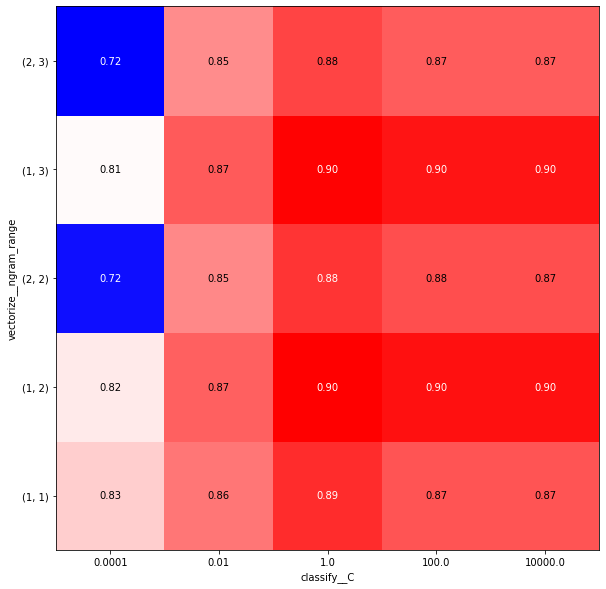

In [63]:
result_tfidf = pd.DataFrame(grid_tfidf.cv_results_)
draw_param_heatmap(
    grid_param_tfidf,
    'classify__C',
    'vectorize__ngram_range',
    result_tfidf
)

In [64]:
pipe_count = Pipeline(
    steps=[
        (
            'vectorize',
            CountVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_count = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

In [65]:
grid_count = GridSearchCV(
    pipe_count,
    grid_param_count,
    cv=5,
    n_jobs=4,
    verbose=1
)

grid_count.fit(train_texts, train_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 18.1min finished


[LibLinear]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        CountVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [66]:
print('The best combination is as follow:')
for param, value in grid_count.best_params_.items():
    if 'vectorize' in param:
        print('count {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_count.best_estimator_.score(test_texts, test_labels)

The best combination is as follow:
SVC C: 0.01
count ngram_range: (1, 2)


0.886

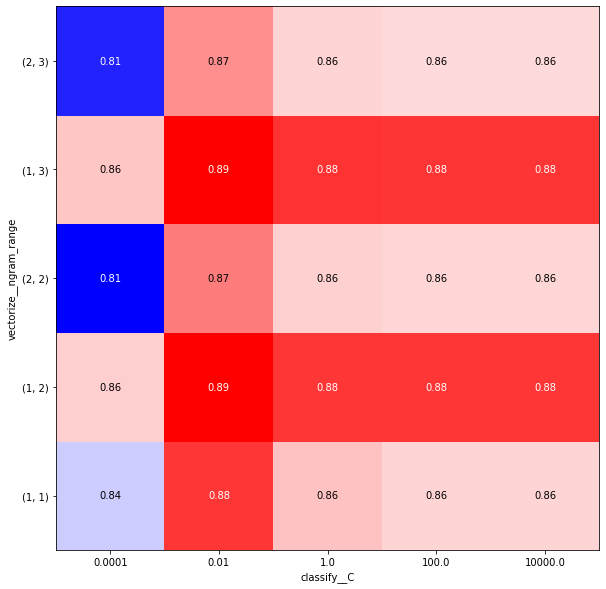

In [67]:
result_count = pd.DataFrame(grid_count.cv_results_)
draw_param_heatmap(
    grid_param_count,
    'classify__C',
    'vectorize__ngram_range',
    result_count
)

Compare to `Tfidf` vectorizing method, `Count` method provides a slightly lower score when pass through a `svm`.

Also the sweet spot of the 2 are also a tad different. While `Count` found its best `C` value at about `C=0.01`, probably because counting didn't take the weight into account while, `Tfidf` already has some degree of that in the weight so it prefers a `C=1`.

However, both shows a better performance in multiple `ngram_range` compare to a single `ngram_range`, meaning `(1, 2)` and `(1, 3)` instead of `(1, 1)` or `(2, 2)`. Humanly speaking that might be because the `svm` is provided about the information about the word itself as well as some form of context.

In [79]:
# # Since I'm doing this in a remote notebook
# # I'll save the trained model for future use
# with open('Model/grid_count.pickle','wb') as f:
#     pickle.dump(grid_count, f)

# with open('Model/grid_count_best.pickle','wb') as f:
#     pickle.dump((
#         grid_count.best_estimator_.steps[0][1],
#         grid_count.best_estimator_.steps[1][1]
#     ), f)

# with open('Model/grid_tfidf.pickle','wb') as f:
#     pickle.dump(grid_tfidf, f)

# with open('Model/grid_ifidf_best.pickle','wb') as f:
#     pickle.dump((
#         grid_tfidf.best_estimator_.steps[0][1],
#         grid_tfidf.best_estimator_.steps[1][1]
#     ), f)

In [120]:
# with open('Model/grid_count.pickle','rb') as f:
#     grid_count = pickle.load(f)

In [127]:
features_count = {
    j: i for i, j
    in grid_count.best_estimator_.steps[0][1].vocabulary_.items()
}

lst_count = [
    (c, i) for i, c in
    enumerate(grid_count.best_estimator_.steps[1][1].coef_[0])
]

lst_count.sort()

In [131]:
for _, i in lst_count[:50]:
    print(features_count[i])
print('----------------------')
for _, i in lst_count[-50:]:
    print(features_count[i])

awful
worst
waste
boring
poorly
terrible
bad
dull
the worst
poor
disappointing
disappointment
save
lacks
mess
annoying
lame
not worth
laughable
horrible
worse
at best
stupid
unfortunately
wonder
waste of
forgettable
oh
not good
just not
dreadful
ridiculous
weak
unfunny
avoid
not even
not recommend
pointless
okay
redeeming
the original
mediocre
pathetic
bored
fails
material
sorry
offensive
way too
than this
----------------------
believable
worth
liked
terrific
powerful
job
fun
10 10
the best
beautiful
much as
underrated
hilarious
enjoyed this
especially
simple
loved this
pretty good
surprisingly
love this
enjoyed
touching
shows
loved
favorite
true
must see
bit
rare
better than
outstanding
very good
wonderfully
definitely worth
to all
fantastic
well worth
refreshing
of what
brilliant
today
amazing
incredible
enjoyed it
wonderful
superb
great
enjoyable
perfect
excellent


Certainly the `ngram_range` had some effects on the features and how the features were used. Words like 'not recommend' was picked up just fine instead of 'recommend' alone for a negative review. Also somehow bad movies are usually sequel because the word 'the original' was quite the determine factor.

#### Now on to the language identification

In [146]:
path_lang = 'language-identification/'
lang_text_train = []
lang_text_val = []
lang_text_test = []
lang_label_train = []
lang_label_val = []
lang_label_test = []
for file in os.listdir(path_lang):
    temp = []
    with open(path_lang + file) as f:
        for line in f:
            temp.append(line)
    if 'train' in file:
        lang_text_train = lang_text_train + temp
        lang_label_train = lang_label_train + [file[:2]]*len(temp)
    if 'devel' in file:
        lang_text_val = lang_text_val + temp
        lang_label_val = lang_label_val + [file[:2]]*len(temp)
    if 'test' in file:
        lang_text_test = lang_text_test + temp
        lang_label_test = lang_label_test + [file[:2]]*len(temp)

In [155]:
print(
    'Number of lines in train text:',
    len(lang_text_train)
)
print(
    'Number of lines in train label:',
    len(lang_label_train)
)
print(
    'Number of lines in validation text:',
    len(lang_text_val)
)
print(
    'Number of lines in validation label:',
    len(lang_label_val)
)
print(
    'Number of lines in test text:',
    len(lang_text_test)
)
print(
    'Number of lines in test label:',
    len(lang_label_test)
)

Number of lines in train text: 5000
Number of lines in train label: 5000
Number of lines in validation text: 5000
Number of lines in validation label: 5000
Number of lines in test text: 5000
Number of lines in test label: 5000


In [154]:
lang_text_train, lang_label_train = shuffle_pair(
    lang_text_train, lang_label_train
)
lang_text_val, lang_label_val = shuffle_pair(
    lang_text_val, lang_label_val
)
lang_text_test, lang_label_test = shuffle_pair(
    lang_text_test, lang_label_test
)

In [164]:
lang_text_train = list(lang_text_train)
lang_label_train = list(lang_label_train)
lang_text_val = list(lang_text_val)
lang_label_val = list(lang_label_val)
lang_text_test = list(lang_text_test)
lang_label_test = list(lang_label_test)

In [172]:
pipe_lang = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_lang = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

pds = PredefinedSplit(
    test_fold=[-1]*len(lang_label_train)+[0]*len(lang_label_val)
)

grid_lang = GridSearchCV(
    pipe_lang,
    grid_param_lang,
#     cv=5,
    cv=pds,
    n_jobs=4,
    verbose=1
)

In [173]:
grid_lang.fit(
    lang_text_train+lang_text_val,
    lang_label_train+lang_label_val
)

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   13.6s finished


[LibLinear]

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                             

In [174]:
print('The best combination is as follow:')
for param, value in grid_lang.best_params_.items():
    if 'vectorize' in param:
        print('lang {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_lang.best_estimator_.score(lang_text_test, lang_label_test)

The best combination is as follow:
SVC C: 1.0
lang ngram_range: (1, 2)


0.9622

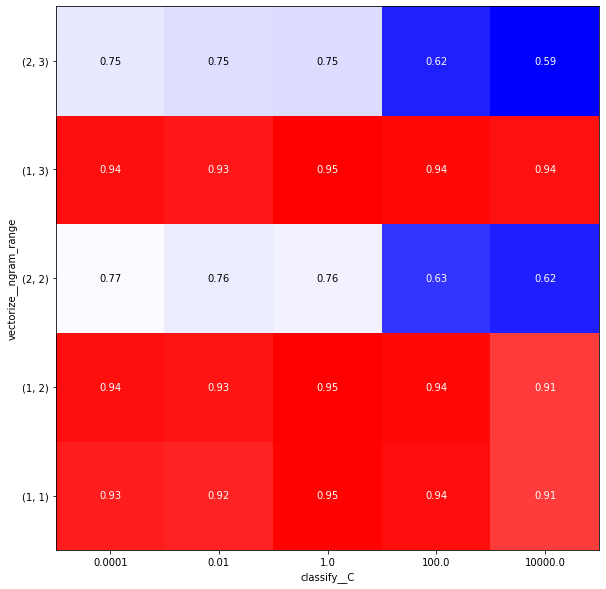

In [175]:
draw_param_heatmap(
    grid_param_lang,
    'classify__C',
    'vectorize__ngram_range',
    pd.DataFrame(grid_lang.cv_results_)
)

In [176]:
# with open('Model/grid_lang_word.pickle','wb') as f:
#     pickle.dump(grid_lang, f)

# with open('Model/grid_lang_word_best.pickle','wb') as f:
#     pickle.dump((
#         grid_lang.best_estimator_.steps[0][1],
#         grid_lang.best_estimator_.steps[1][1]
#     ), f)